## OVERVIEW
---
* Image Preprocessing with OpenCV
    * Masking
    * Segmentation
    * Image Sharpening
* Transfer Learning with Keras Pretrained Model
* Feature Extraction
* Deep Learning Model to Classify the Images

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob


from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import np_utils, to_categorical



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

ImportError: cannot import name 'np_utils' from 'keras.utils' (/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/utils/__init__.py)

In [ ]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
!ls ~/.keras/models

xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
base_folder = '../input/fire-dataset'
data_folder = '../input/fire-dataset/fire_dataset'
train_data_folder = '../input/fire-dataset/fire_dataset/fire_images'
test_date_folder  = '../input/fire-dataset/fire_dataset/non_fire_images'

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [ ]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 49.02it/s]


In [ ]:
#show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


In [ ]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(999, 3)

,file,id,label
0,fire_images/fire.562.png,0,fire_images
1,fire_images/fire.604.png,0,fire_images
2,fire_images/fire.251.png,0,fire_images
3,fire_images/fire.537.png,0,fire_images
4,fire_images/fire.313.png,0,fire_images


### IMAGE PREPROCESSING

In [ ]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

### SHOW SAMPLE IMAGES

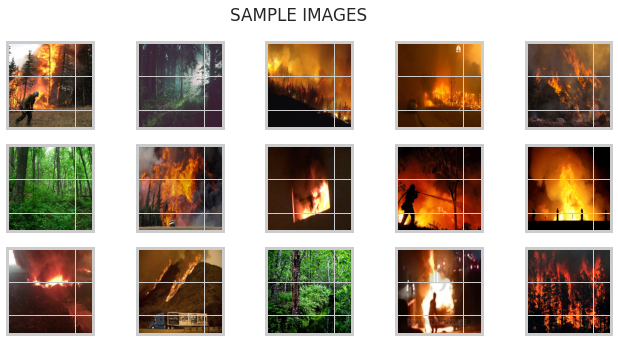

In [ ]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

### SHOW SAMPLE PROCESSED IMAGE


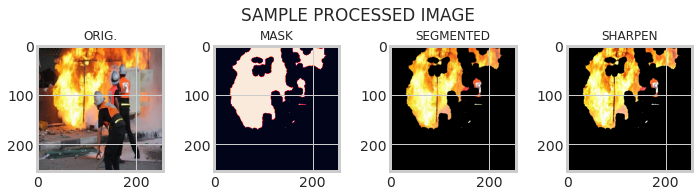

In [ ]:
#get an image
img = read_img(df['file'][102],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);



### XCEPTION BOTTLENECK FEATURE EXTRACTION

In [ ]:
INPUT_SIZE=255

##preprocess the input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #read image
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

999it [01:20, 12.42it/s]


In [ ]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (999, 255, 255, 3)
Train Image Size:  194879925


#### SPLIT THE DATA

In [ ]:
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [ ]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

FIRE IMAGES ON TRAINING DATA:  610
NON-FIRE IMAGES ON TRAINING DATA:  189


In [ ]:
##get the features
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

7/7 [==============================] - 1s 112ms/step


In [ ]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (799, 2048)
Train Size:  1636352
Validation Shape:  (200, 2048)
Validation Size:  409600


### DEEP LEARNING MODEL

In [ ]:
#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_30 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

Epoch 1/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5352 - accuracy: 0.7584
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4681 - accuracy: 0.7647
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4027 - accuracy: 0.8085
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3692 - accuracy: 0.8260
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3273 - accuracy: 0.8536
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3154 - accuracy: 0.8561
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.2868 - accuracy: 0.8761
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.2911 - accuracy: 0.8636
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 0.2607 - accuracy: 0.8836
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - loss: 0.2496 - accuracy: 0.8886
Epoch 11/

25/25 [==============================] - 0s 3ms/step - loss: 0.0967 - accuracy: 0.9574
Epoch 84/100
25/25 [==============================] - 0s 3ms/step - loss: 0.1015 - accuracy: 0.9599
Epoch 85/100
25/25 [==============================] - 0s 3ms/step - loss: 0.1074 - accuracy: 0.9562
Epoch 86/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0937 - accuracy: 0.9625
Epoch 87/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0947 - accuracy: 0.9637
Epoch 88/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0823 - accuracy: 0.9637
Epoch 89/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0926 - accuracy: 0.9587
Epoch 90/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0941 - accuracy: 0.9524
Epoch 91/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0788 - accuracy: 0.9650
Epoch 92/100
25/25 [==============================] - 0s 3ms/step - loss: 0.1039 - accuracy: 0.9549
Epoch 93/100


#### LOSS AND ACCURACY

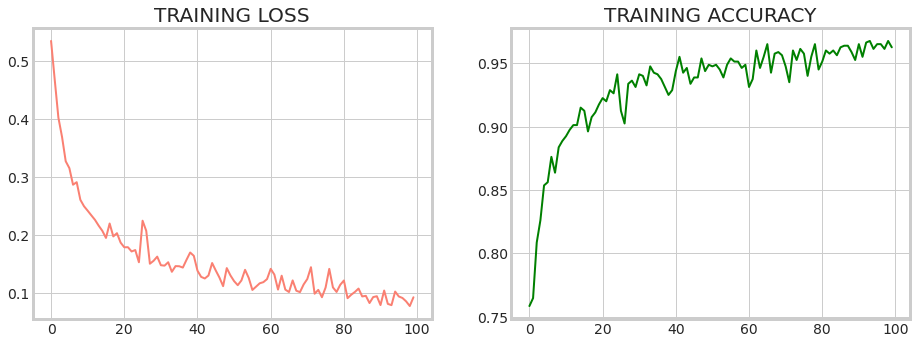

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [ ]:
#predict the validation data
predictions = model.predict_classes(bf_train_val)

#### CLASSIFICATION REPORT

In [ ]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       145
           1       0.77      0.84      0.80        55

    accuracy                           0.89       200
   macro avg       0.85      0.87      0.86       200
weighted avg       0.89      0.89      0.89       200



#### CONFUSION MATRIX

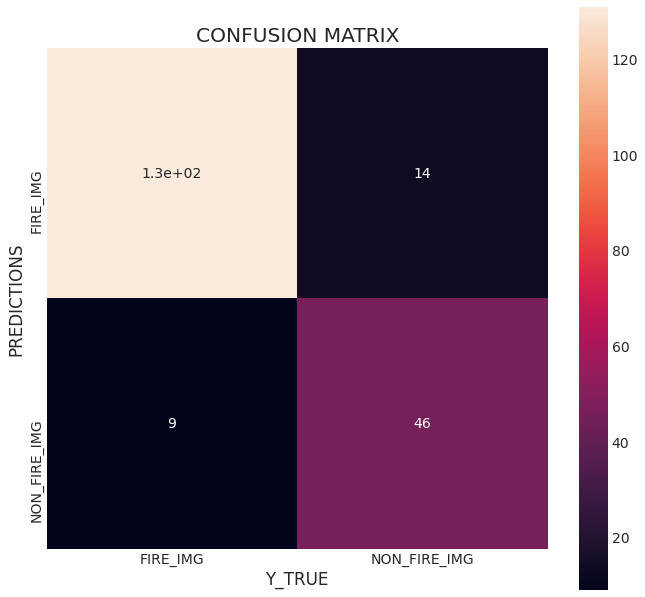

In [ ]:
confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");